In [24]:
import numpy as np
import pydicom
import cv2
import torch
import segmentation_models_pytorch as smp
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
from skimage.transform import resize
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


margin = 50
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

def normalize_uint(image):
    # 입력 받은 numpy array를 0.3 quantile과 0.99 quantile을 기준으로 min max scaleing
    min_val = np.quantile(image.reshape(-1), 0.3)
    max_val = np.quantile(image.reshape(-1), 0.99)
    # 1차 threshold 적용                   
    over_idx  = (image > max_val)
    under_idx = (image < min_val)
    image[over_idx]  = max_val
    image[under_idx] = min_val
    normalized = (image - min_val) / (max_val - min_val) * 255    
    return normalized.astype(np.uint8)

def normalize_float(image):
    max_val = image.max()
    min_val = image.min()
    normalized = (image - min_val) / (max_val - min_val)
    return normalized

def apply_margin(image, margin):
    if margin == 0:
        return image
    else:
        # 입력 받은 이미지의 상하좌우로 margin을 적용하고
        # 원본 크기로 resize하여 반환
        image_margin = np.zeros(image.shape)
        for z in range(image.shape[0]):
            sample = image[z, margin:-margin,margin:-margin].copy()
            image_margin[z, :,:] = cv2.resize(sample, (512, 512))
        return image_margin
    


def export_num(string):
    # 파일이름에서 숫자를 추출
    # ex) "00006021_converted_138.dcm" -> 138
    find_num = re.compile('[0-9]+')
    number = find_num.findall(string[-10:])
    return int(number[0])

def load_image(dir_path):
    # dir_path에 들어있는 dcm파일을 읽어서 3d numpy array로 반환
    file_list = os.listdir(dir_path)
    dcm_list = []
    for idx, file in enumerate(file_list):
        if "dcm" in file:
            dcm_list.append(file)     
    file_df = pd.DataFrame(
                            {"file_name" : dcm_list},
                            index = list(map(export_num, dcm_list))
                           ).sort_index()
    image_3d = np.zeros((512,512, len(file_df)))
    for z, image_2d_path in enumerate(dcm_list):
        image_2d = np.array(pydicom.dcmread(dir_path + '/' + file_df.iloc[z,0]).pixel_array)
        image_3d[:,:,z] = image_2d
        
    start = pydicom.dcmread(dir_path + '/' + file_df.iloc[0,0])
    end = pydicom.dcmread(dir_path + '/' + file_df.iloc[-1,0])
    start_loc = start.ImagePositionPatient[-1]
    end_loc = end.ImagePositionPatient[-1]
    z_length = start_loc - end_loc
    z_unit = z_length / image_3d.shape[2]
    xy_unit  = float(start.PixelSpacing[0])
    return image_3d, xy_unit, z_unit

def predict(image, model):
    # 3차원 입력을 받아서 추론하고 출력 [샘플 수, 세로축, 가로축]
    #image = image[..., np.newaxis]
    image = image.astype('float32')[:,np.newaxis,...]#[샘플수, 채널 수(1), 세로축, 가로축]
    image_tensor = torch.cuda.FloatTensor(image).to(device)
    predict_mask = model.predict(image_tensor).cpu().numpy()
    return predict_mask


def gen_padding(image, mul = 4):
    # saggital plane(2차원)을 입력으로 받음
    # 입력받은 이미지의 z축을 4배로 resize
    # 가로 세로 비율을 유지하면서 z축을 512로 resize
    # y축을 기준으로 상하 padding을 적용하여 512,512이미지 생성
    
    # (x_size, z_size)크기의 이미지 입력, x_size == 512
    # x_size : x축 길이, 512로 고정 o
    x_size = image.shape[0]
    # z_size : x축의 길이, 고정 x
    z_size = image.shape[1]
    
    
    # axis 1의 크기를 4배로 resize
    mul_z_size =  z_size*mul
    resized_mul = cv2.resize(image, (x_size, mul_z_size)).T
    
    # axis 1 크기를 512로 바꿀 때,
    # axis 0의 크기 계산
    # x_size : mul_z_size  = ??? : 512
    # ??? = 512 * x_size / mul_z_size
    x_resize = int(512 * x_size / mul_z_size)
    
    
    # 가로 세로 비율을 유지하면서 axis 1의 크기를 512로 resize
    resized_512 = cv2.resize(resized_mul, (x_resize, 512)).T
    padding_image = np.zeros([512, 512])
    padding_size = (512 - x_resize) // 2
    padding_image[padding_size:padding_size + resized_512.shape[0],:] = resized_512    
    return padding_image


def mask_to_loc(sagittal_mask):
    # 모델이 예측한 sagittal_mask를 입력으로 받음
    # sagittal_mask를 바탕으로 l3의 위치를 계산하여 반환
    col_index = sagittal_mask[:,:].sum(axis = 0) > sagittal_mask.shape[1]/2
    re_pred = np.zeros(sagittal_mask.shape)
    re_pred[:, col_index] = 1
    l3_loc = int(np.median(np.argwhere(col_index)))
    return l3_loc


def mask_to_area(l3_mask, xy_unit):
    musle = (l3_mask == 0)
    visceral = (l3_mask == 1)
    subcutaneous = (l3_mask == 2)
    abdomen = l3_mask != 3
    
    kernel = np.ones((20, 20), np.uint8)
    abdomen = cv2.dilate(abdomen.astype(np.uint8), kernel, iterations=1)  #// make dilation image
    abdomen = cv2.erode(abdomen.astype(np.uint8), kernel, iterations=1)  #// make erosion image
    
    contours, _ = cv2.findContours(abdomen, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_area = 0
    for cont in contours:
        area = cv2.contourArea(cont)
        if area > max_area:
            max_area = area
            max_contour = cont

    abdomen_area = max_area
    musle_area = musle.sum()
    visceral_area = visceral.sum()
    subcutaneous_area = subcutaneous.sum()
    other_area = abdomen_area - musle_area\
                                -visceral_area\
                                    -subcutaneous_area
    
    slice_df = pd.DataFrame(np.zeros((4,1)),
                        columns = ['area[mm^2]'],
                        index = ['muscle',
                                 'visceral',
                                 'subcutaneous',
                                 'other'])     
    
    slice_df.loc['muscle', 'area[mm^2]'] = musle_area * (xy_unit**2)
    slice_df.loc['visceral', 'area[mm^2]'] = visceral_area * (xy_unit**2)
    slice_df.loc['subcutaneous', 'area[mm^2]'] = subcutaneous_area * (xy_unit**2)
    slice_df.loc['other', 'area[mm^2]'] = other_area * (xy_unit**2)
    return slice_df

def slice_to_vol(slice_list, z_unit):
    vol_array = np.array(slice_list)    
    vol = vol_array.sum(axis = 0).reshape(-1,1) * z_unit
    vol_df = pd.DataFrame(vol,
                            columns = ['volume[mm^3]'],
                            index = ['muscle',
                                     'visceral',
                                     'subcutaneous',
                                     'other'])
    return vol_df


def draw_3d_plot(image,
                 visceral_3d,
                 muscle_3d,
                 subcutaneous_3d):
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    alpha = 0.1
    image_p = image.transpose(2,1,0)

    for threshold in np.arange(0.4, 0.7, 0.1):
        alpha = alpha * 0.5
        verts, faces, normals, values = measure.marching_cubes_lewiner(image_p, threshold)
        mesh = Poly3DCollection(verts[faces], alpha=alpha)
        face_color = [0, 0, 0]
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)

    visceral_p = visceral_3d.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(visceral_p, 0.5)
    mesh = Poly3DCollection(verts[faces], alpha=1)
    face_color = [1, 0, 0]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    muscle_p = muscle_3d.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(muscle_p, 0.5)
    mesh = Poly3DCollection(verts[faces], alpha=0.3)
    face_color = [0, 0.8, 0]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    subcutaneous_p = subcutaneous_3d.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(subcutaneous_p, 0.5)
    mesh = Poly3DCollection(verts[faces], alpha=0.2)
    face_color = [0, 0, 0.5]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)


    ax.set_xlim(0, image_p.shape[0])
    ax.set_ylim(0, image_p.shape[1])
    ax.set_zlim(0, image_p.shape[2])

    ax.axis('off')
    fig = plt.gcf()
    fig.savefig(output_dir + "/" + 'predict_3d.png',
                bbox_inches = 'tight', pad_inches=0)

    plt.show()

/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/ipykernel_launcher.py:200: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/ipykernel_launcher.py:207: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/ipykernel_launcher.py:214: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/ipykernel_launch

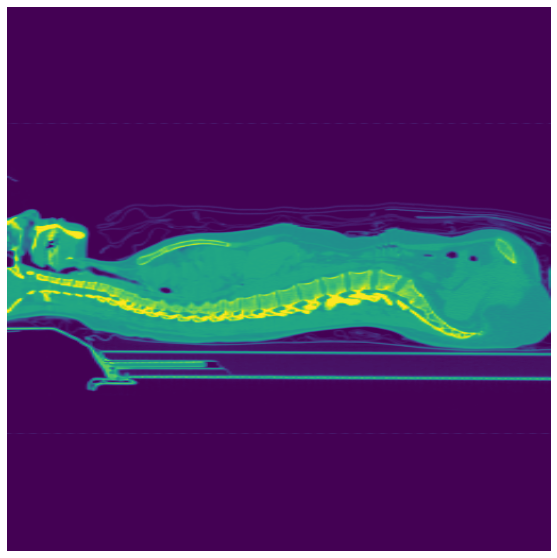

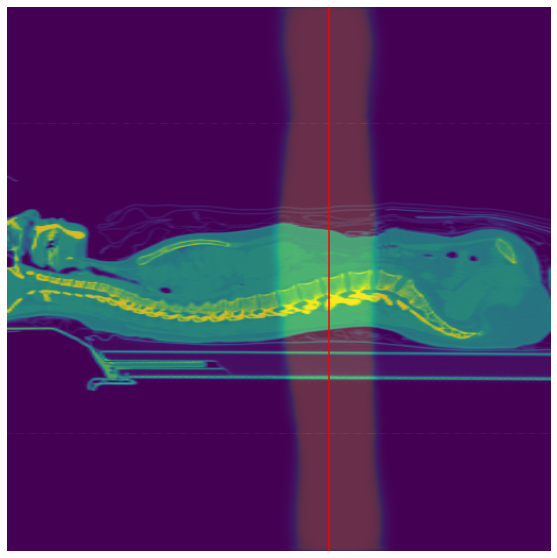

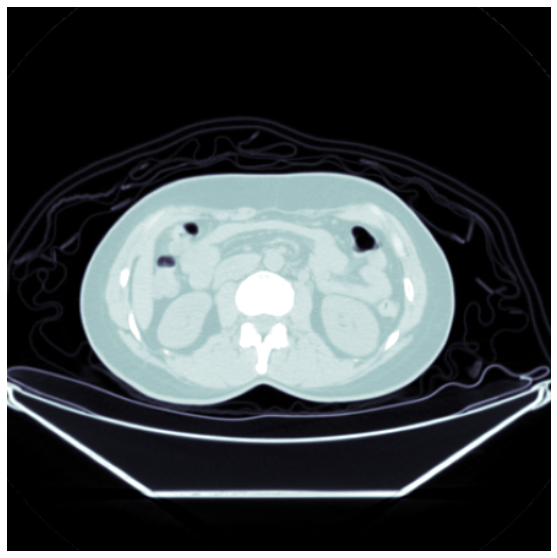

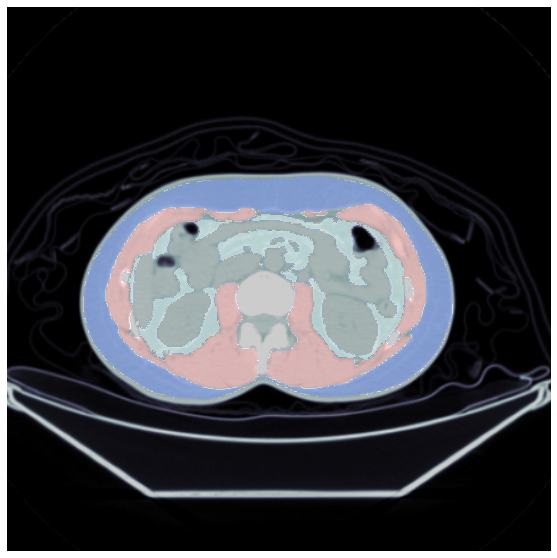

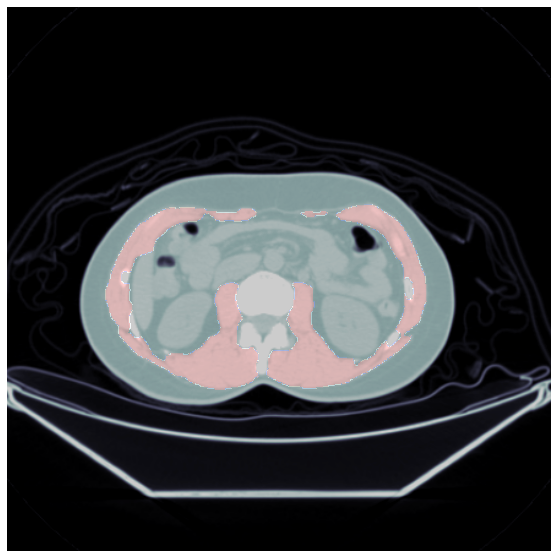

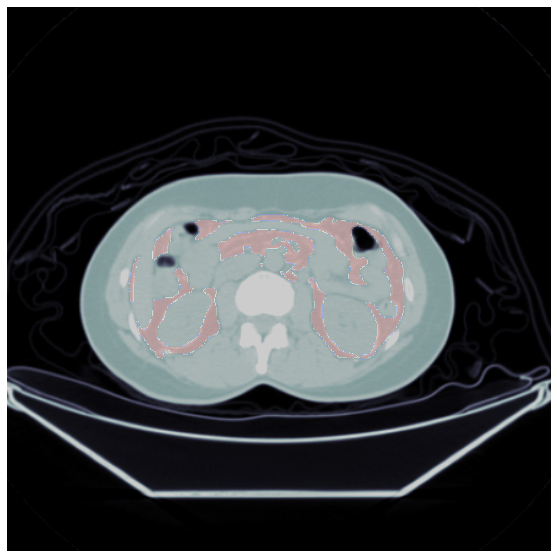

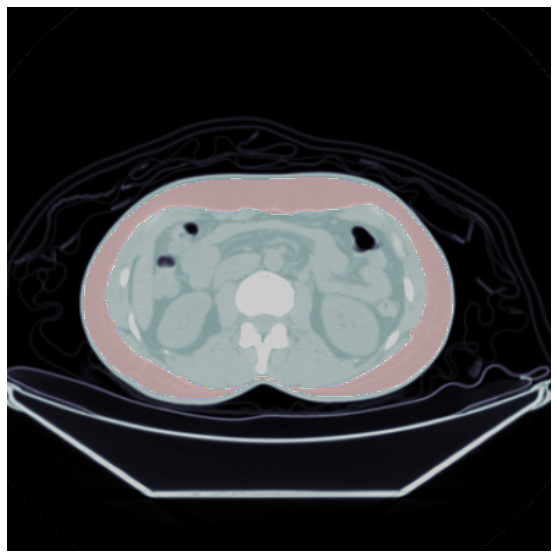

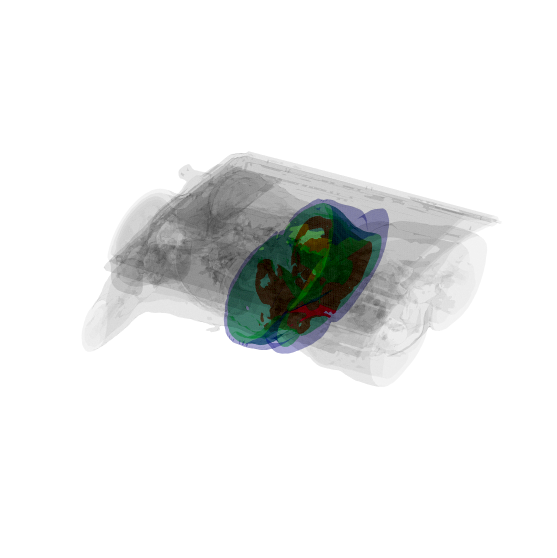

,volume[mm^3]
muscle,1.521388e+06
visceral,7.230896e+05
subcutaneous,1.334603e+06
other,2.043374e+06


,area[mm^2]
muscle,14186.727228
visceral,6050.518805
subcutaneous,17827.754265
other,7976.636861


In [26]:
#if __name__ == "__main__":
# input path
#if sys.argv[1] == '-input_dir':
input_dir = 'input'
#if sys.argv[3] == '-output_dir':
output_dir = 'output'
#if sys.argv[5] == '-models_dir':
models_dir = 'models'
#if sys.argv[7] == '-window_size':
z_length = 130

with torch.no_grad():    
    #모델 불러오기-------------------------------------------------------------
    # abdomen영역을 detect 모델
    detect_model = torch.load(models_dir  + "/" + "detect_model.pth", device)
    # abdomen에서 musle, visceral, subcutaneous를 segment 모델
    segment_model = torch.load(models_dir + "/" + "segment_model.pth", device)


    #3차원 이미지 불러오기 불러오기--------------------------------------------
    image_3d, xy_unit, z_unit = load_image(input_dir)
    window_size = int(z_length // z_unit // 2)

    # detect abdomen
    sagittal = image_3d[:,256,:]
    sagittal_normal = normalize_uint(sagittal)
    sagittal_normal = normalize_float(sagittal_normal)
    sagittal_padding = gen_padding(sagittal_normal)[np.newaxis, ...]
    sagittal_mask = predict(sagittal_padding, detect_model)[0,0,...]

    l3_loc_padding = mask_to_loc(sagittal_mask) #추가 정의 필요
    l3_loc = int(sagittal.shape[1] * (l3_loc_padding / sagittal.shape[0]))

    # draw sagittal plane plots
    plt.figure(figsize = (10,10))
    plt.imshow(sagittal_padding[0,...])
    ax = plt.gca()
    ax.axis('off')
    fig = plt.gcf()
    fig.savefig(output_dir + "/" + 'sagittal.png',
                bbox_inches='tight', pad_inches=0)


    plt.figure(figsize = (10,10))
    plt.imshow(sagittal_padding[0,...])
    plt.imshow(sagittal_mask, alpha = 0.2)
    plt.axvline(l3_loc_padding, c = 'red')
    ax = plt.gca()
    ax.axis('off')
    fig = plt.gcf()
    fig.savefig(output_dir + "/" + 'sagittal_overray.png',
                bbox_inches='tight', pad_inches=0)
    #--------------------------------------------------------------------------

    # segment abdomen
    predict_mask_3d = np.zeros([512,512,40])
    #window = 1 # 연상량이 충분하다면 20으로 설정
    horizontal_stack = image_3d[:,:,
                                l3_loc - window_size : l3_loc + window_size]\
                        .transpose(2, 0, 1)
    # 정규화
    horizontal_normal  = normalize_uint(horizontal_stack)
    
    # 마진 적용
    horizontal_normal = apply_margin(horizontal_normal, margin = margin)
    margin_ratio = (512 - margin) / (512)
    
    # minmax
    horizontal_normal  = normalize_float(horizontal_normal)
    
    # 예측
    sagittal_mask = predict(horizontal_normal, segment_model)#[0,0,...]
    horizontal_mask = sagittal_mask.transpose([0, 2, 3, 1]).argmax(axis = 3)
    horizontal_mask = (horizontal_mask * 255 / 3).astype(np.uint8)

    # horizontal 원본
    plt.figure(figsize = (10,10))
    plt.imshow(horizontal_normal[window_size,...], cmap = 'bone')
    ax = plt.gca()
    ax.axis('off')
    fig = plt.gcf()
    fig.savefig(output_dir + "/" + 'horizontal.png',
                bbox_inches='tight', pad_inches=0)

    # horizontal 전부 중복
    plt.figure(figsize = (10,10))
    plt.imshow(horizontal_normal[window_size,...], cmap = 'bone')
    plt.imshow(horizontal_mask[window_size,...], alpha = 0.2, cmap = 'flag')
    ax = plt.gca()
    ax.axis('off')
    fig = plt.gcf()
    fig.savefig(output_dir + "/" + 'horizontal_overray.png',
                bbox_inches='tight', pad_inches=0)

    # horizontal muscle 중복
    plt.figure(figsize = (10,10))
    plt.imshow(horizontal_normal[window_size,...], cmap = 'bone')
    muscle = horizontal_mask[window_size,...]/255*3 != 0
    plt.imshow(muscle.astype(np.uint8)*255, alpha = 0.2, cmap = 'flag')
    ax = plt.gca()
    ax.axis('off')
    fig = plt.gcf()
    fig.savefig(output_dir + "/" + 'muscle_overray.png',
                bbox_inches='tight', pad_inches=0)

    # horizontal visceral 중복
    plt.figure(figsize = (10,10))
    plt.imshow(horizontal_normal[window_size,...], cmap = 'bone')
    visceral = horizontal_mask[window_size,...]/255*3 != 1
    plt.imshow(visceral.astype(np.uint8)*255, alpha = 0.2, cmap = 'flag')
    ax = plt.gca()
    ax.axis('off')
    fig = plt.gcf()
    fig.savefig(output_dir + "/" + 'visceral_overray.png',
                bbox_inches='tight', pad_inches=0)

    # horizontal subcutaneous 중복
    plt.figure(figsize = (10,10))
    plt.imshow(horizontal_normal[window_size,...], cmap = 'bone')
    subcutaneous = horizontal_mask[window_size,...]/255*3 != 2
    plt.imshow(subcutaneous.astype(np.uint8)*255, alpha = 0.2, cmap = 'flag')
    ax = plt.gca()
    ax.axis('off')
    fig = plt.gcf()
    fig.savefig(output_dir + "/" + 'subcutaneous_overray.png',
                bbox_inches='tight', pad_inches=0)
    #--------------------------------------------------------------------------
    slice_list = []
    for z in range(horizontal_mask.shape[0]):
        l3_mask = horizontal_mask[z] / 255 * 3 
        slice_area = mask_to_area(l3_mask, xy_unit)
        slice_area = slice_area * margin_ratio**2
        slice_list.append(slice_area['area[mm^2]'].values.copy())
        if z == window_size:
            slice_area.to_csv(output_dir + '/' + "slice_df.csv")
    vol_df = slice_to_vol(slice_list,z_unit)
    vol_df.to_csv(output_dir + '/' + "vol_df.csv")

    #--------------------------------------------------------------------------    
    start = l3_loc  - horizontal_mask.shape[0] // 2
    end = start + horizontal_mask.shape[0]
    predict_mask = np.zeros(image_3d.shape)
    predict_mask[...] = -1
    predict_mask[:,:,start:end] = (horizontal_mask / 255 * 3).transpose(1,2,0)
    np.save(output_dir +"/predict_mask.npy", predict_mask.astype(np.uint8))
    #--------------------------------------------------------------------------

    # 3차원 plot 그리기 데이터 생성
    muscle_3d = (predict_mask == 0) * 255
    visceral_3d = (predict_mask== 1) * 255
    subcutaneous_3d = (predict_mask == 2) * 255

    # resize
    image = resize(image_3d, (100, 100, 180), mode='constant')
    muscle_3d = resize(muscle_3d, (100, 100, 180), mode='constant')
    visceral_3d = resize(visceral_3d, (100, 100, 180), mode='constant')
    subcutaneous_3d = resize(subcutaneous_3d, (100, 100, 180), mode='constant')

    # normalization
    image = normalize_float(image)
    muscle_3d = normalize_float(muscle_3d)
    visceral_3d = normalize_float(visceral_3d)
    subcutaneous_3d = normalize_float(subcutaneous_3d)

    # draw plot
    draw_3d_plot(image,visceral_3d,
                muscle_3d,subcutaneous_3d)
        #--------------------------------------------------------------------------
    #display(vol_df)
    #display(slice_area)
    #--------------------------------------------------------------------------
display(vol_df)
display(slice_area)

In [19]:
horizontal_normal.shape

(38, 512, 512)

In [14]:
z_unit * 40

130.2134532735426

In [6]:
z_unit

3.2553363318385653

In [5]:
 (512 - margin) / (512)

0.90234375

In [36]:
margin = 50


In [ ]:
abdomen
13.8 cm < 근육을 포함한 영역
26.10 cm < 지방을 포함한 영역

In [15]:
import numpy as np
import pydicom
import cv2
import torch
import segmentation_models_pytorch as smp
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
from utils_ct import *
from skimage.transform import resize
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import warnings

In [26]:
import skimage
import mpl_toolkits

In [27]:
skimage.__version__

'0.17.2'

In [28]:
smp.__version__

'0.1.3'

In [31]:
pydicom.__version__

'2.1.2'

In [30]:
mpl_toolkits.__version__

AttributeError: module 'mpl_toolkits' has no attribute '__version__'

/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  
/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  from ipykernel import kernelapp as app


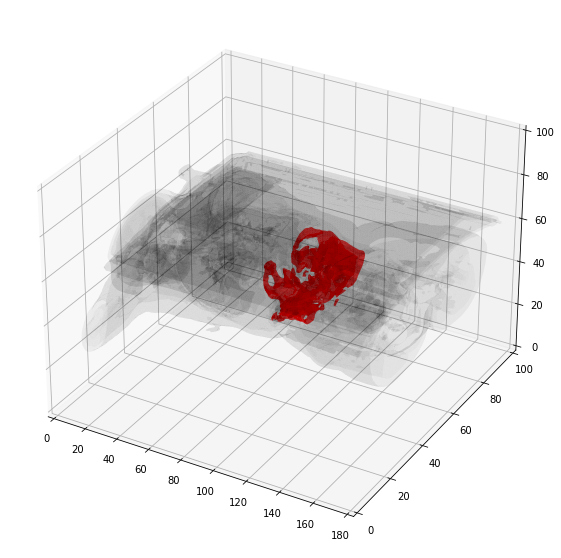

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

alpha = 0.1
image_p = image.transpose(2,1,0)
for threshold in np.arange(0.4, 0.7, 0.1):
    alpha = alpha * 0.5
    verts, faces, normals, values = measure.marching_cubes_lewiner(image_p, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=alpha)
    face_color = [0, 0, 0]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

visceral_p = visceral_3d.transpose(2,1,0)
verts, faces, normals, values = measure.marching_cubes_lewiner(visceral_p, 0.5)
mesh = Poly3DCollection(verts[faces], alpha=0.5)
face_color = [1, 0, 0]
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

ax.set_xlim(0, p.shape[0])
ax.set_ylim(0, p.shape[1])
ax.set_zlim(0, p.shape[2])
plt.show()

/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  
/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  app.launch_new_instance()


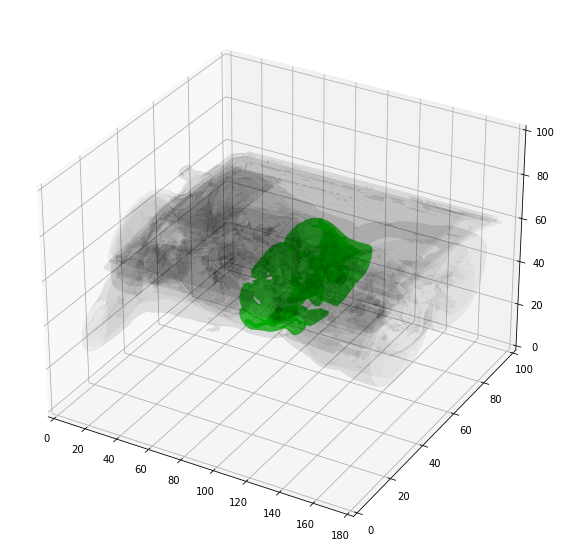

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

alpha = 0.1
image_p = image.transpose(2,1,0)
for threshold in np.arange(0.4, 0.7, 0.1):
    alpha = alpha * 0.5
    verts, faces, normals, values = measure.marching_cubes_lewiner(image_p, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=alpha)
    face_color = [0, 0, 0]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)


muscle_p = muscle_3d.transpose(2,1,0)
verts, faces, normals, values = measure.marching_cubes_lewiner(muscle_p, 0.5)
mesh = Poly3DCollection(verts[faces], alpha=0.5)
face_color = [0, 0.8, 0]
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

ax.set_xlim(0, p.shape[0])
ax.set_ylim(0, p.shape[1])
ax.set_zlim(0, p.shape[2])
plt.show()

/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  
/home/ubuntu/anaconda3/envs/bdg/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  from ipykernel import kernelapp as app


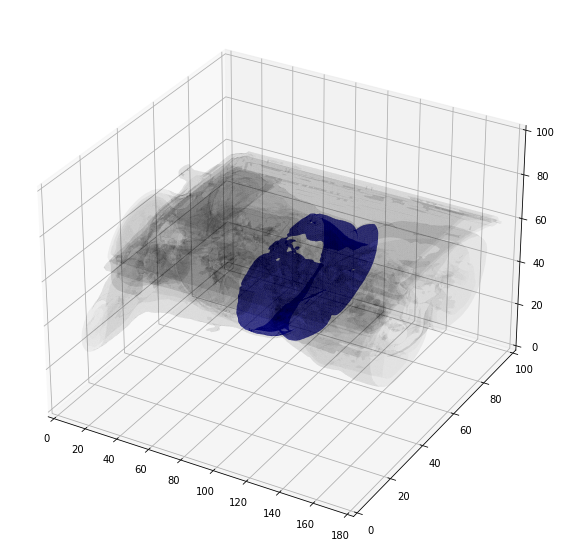

In [25]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

alpha = 0.1
image_p = image.transpose(2,1,0)
for threshold in np.arange(0.4, 0.7, 0.1):
    alpha = alpha * 0.5
    verts, faces, normals, values = measure.marching_cubes_lewiner(image_p, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=alpha)
    face_color = [0, 0, 0]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

subcutaneous_p = subcutaneous_3d.transpose(2,1,0)
verts, faces, normals, values = measure.marching_cubes_lewiner(subcutaneous_p, 0.5)
mesh = Poly3DCollection(verts[faces], alpha = 0.5)
face_color = [0, 0, 0.5]
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

ax.set_xlim(0, p.shape[0])
ax.set_ylim(0, p.shape[1])
ax.set_zlim(0, p.shape[2])
plt.show()